In [1]:
from Oanda_Data import OandaData
from ENGINE.DATALAKE.TIMESERIES.OHLC_Manipulate import OHLC_DF_to_REGRESSION_C, OHLC_DF_to_CLASSIFICATION_C
from ENGINE.DATALAKE.TIMESERIES.Data_to_PytorchForecasting import DF_to_TSDataSet
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [2]:
OD = OandaData()
data = OD.GetData("2020-01-01T00:00:00Z", "2021-04-21T00:00:00Z", "EUR_USD", "M15", "DF")
df = OHLC_DF_to_REGRESSION_C(data)
training, train_dataloader, val_dataloader = DF_to_TSDataSet(df,max_encoder_length=60,max_prediction_length=1)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [3]:
baseline_predictions = Baseline().predict(val_dataloader)
value = SMAPE()(baseline_predictions, actuals)
print(value)

tensor(0.0002)


In [4]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=15,
    # limit_val_batches=1,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [5]:
net = NBeats.from_dataset(
    training, learning_rate=0.0014125375446227544, log_interval=10, log_val_interval=1, log_gradient_flow=False, weight_decay=1e-2
)
print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

Number of parameters in network: 1683.6k


In [6]:
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.735     Total estimated model params size (MB)


1

In [7]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [8]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
value = (actuals - predictions).abs().mean()
print(value)

tensor(2.8491e-05)


In [9]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [10]:
raw_predictions

{'prediction': tensor([[1.2032]]),
 'target_scale': tensor([[1.2041e+00, 1.1075e-03]]),
 'backcast': tensor([[-0.7382, -0.7371, -0.7360, -0.7349, -0.7339, -0.7330, -0.7322, -0.7314,
          -0.7307, -0.7301, -0.7295, -0.7290, -0.7286, -0.7282, -0.7280, -0.7277,
          -0.7276, -0.7275, -0.7274, -0.7275, -0.7276, -0.7278, -0.7280, -0.7283,
          -0.7287, -0.7292, -0.7297, -0.7303, -0.7309, -0.7316, -0.7324, -0.7333,
          -0.7342, -0.7352, -0.7362, -0.7373, -0.7385, -0.7398, -0.7411, -0.7425,
          -0.7440, -0.7455, -0.7471, -0.7488, -0.7505, -0.7523, -0.7542, -0.7561,
          -0.7581, -0.7602, -0.7623, -0.7645, -0.7668, -0.7691, -0.7715, -0.7740,
          -0.7765, -0.7792, -0.7818, -0.7846]]),
 'trend': tensor([[-0.7382, -0.7371, -0.7360, -0.7349, -0.7339, -0.7330, -0.7322, -0.7314,
          -0.7307, -0.7301, -0.7295, -0.7290, -0.7286, -0.7282, -0.7280, -0.7277,
          -0.7276, -0.7275, -0.7274, -0.7275, -0.7276, -0.7278, -0.7280, -0.7283,
          -0.7287, -0.

IndexError: index 1 is out of bounds for dimension 0 with size 1

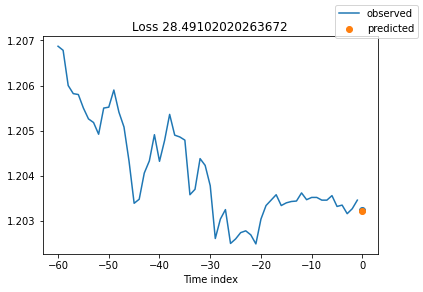

In [11]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);